# Convolutional Neural Networks (CNN)

Este notebook corresponde a atividade prática da seção 3.5 no livro do curso. Nesta atividade você desevolverá uma CNN (ConvNet) para reconhecer imagens de sinais de mão. O dataset usado neste exemplo foi obtido no curso de especialização em Deep Learning do professor <a href="https://www.deeplearning.ai/">Andrew Ng. (deeplearning.ai)</a>. O dataset é composto por 1200 fotos de sinais de mão no formato RGB com dimensões 64x64.

## 1 - Pacotes

Rode o bloco abaixo para importar os pacotes necessarios. 

- [tensorflow](https://www.tensorflow.org/)um framework para machine learning.
- [numpy](www.numpy.org) pacote de bilbiotecas para computação científica.
- [matplotlib](http://matplotlib.org) biblioteca para desenho de gráficos.
- [pandas]() bibliotecas para algoritmos de machine learning.
- [sklearn.preprocessing](http://scikit-learn.org) pacote do scikit-learn para pré-processamento de datasets 

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

#código local com funções úteis
from cnn_utils import *

#
%matplotlib inline
np.random.seed(1)

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 2 - Carregando e tratando o dataset

In [2]:
# carregando os datasets de treino e teste
X_train, Y_train, X_test, Y_test, classes = load_dataset()

#imprimindo o shape dos datasets
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080,)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120,)


A Figura abaixo ilustra os seis tipos de sinais de mão encontrados no dataset, bem como os respectivos labels codificados no formato OneHot.

<img src="images/SIGNS.png" style="width:800px;height:300px;">

o exemplo número 6 é um 2


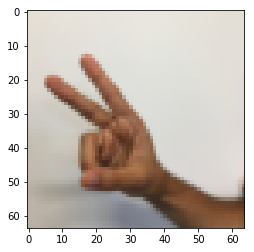

In [3]:
#Exibindo um exemplo
index = 6
plt.imshow(X_train[index])
print ("o exemplo número", index,"é um", Y_train[index])

## 3 - Modelando uma CNN

O código abaixo mostra a construção de uma arquitetura de CNN. A função "build_cnn" recebe como parâmetro a largura, altura e número de canais da imagem de entrada, bem como o número de classes do problema. No decorrer da definição das camadas convolutivas, os shapes dos tensores são impressos para debugging.

In [4]:
def build_cnn(input_width, input_height, input_channels, n_classes):
    
    #Por praticidade os tensores são salvos neste dicionário
    Dic = {}
    
    # ---- INICIO DA REDE NEURAL ----
    
    #placeholders
    placeholder_X = tf.placeholder(tf.float32, shape=(None, input_width, input_height, input_channels))
    Dic["placeholder_X"] = placeholder_X
    
    placeholder_Y = tf.placeholder(tf.int64, shape=(None))
    Dic["placeholder_Y"] = placeholder_Y
    
    initializer = tf.contrib.layers.xavier_initializer(seed = 0)

    #camada convolucao 1
    conv2d_1 = tf.layers.conv2d(inputs=placeholder_X, filters=4, kernel_size=[3,3], strides=1, activation=tf.nn.relu, padding = 'SAME', kernel_initializer=initializer)
    Dic["conv2d_1"] = conv2d_1
    print("conv2d_1", conv2d_1.get_shape())
    
    #camada convolucao 2
    conv2d_2 = tf.layers.conv2d(inputs=conv2d_1, filters=4, kernel_size=[3,3], strides=1, activation=tf.nn.relu, padding = 'SAME', kernel_initializer=initializer)
    Dic["conv2d_2"] = conv2d_2
    print("conv2d_2", conv2d_2.get_shape())
    
    #camada max pooling 1
    maxpool_1 = tf.layers.max_pooling2d(inputs=conv2d_2, pool_size=[8, 8], strides=2, padding = 'SAME')
    Dic["maxpool_1"] = maxpool_1
    print("max_pool2d_1", maxpool_1.get_shape())    
    
    #camada convolucao 3
    conv2d_3 = tf.layers.conv2d(inputs=maxpool_1, filters=8, kernel_size=[3,3] ,strides=1, activation=tf.nn.relu, padding = 'SAME', kernel_initializer=initializer)
    Dic["conv2d_3"] = conv2d_3
    print("conv2d_3", conv2d_3.get_shape())
    
    #camada pooling 2
    maxpool_2 = tf.layers.max_pooling2d(inputs=conv2d_3, pool_size=[8, 8], strides=2, padding = 'SAME')
    Dic["maxpool_2"] = maxpool_2
    print("max_pool2d_2", maxpool_2.get_shape())
    
    #camada convolucao 4
    conv2d_4 = tf.layers.conv2d(inputs=maxpool_2, filters=16, kernel_size=[3,3] ,strides=1, activation=tf.nn.relu, padding = 'SAME', kernel_initializer=initializer)
    Dic["conv2d_4"] = conv2d_3
    print("conv2d_4", conv2d_3.get_shape())
    
    #camada pooling 3
    maxpool_3 = tf.layers.max_pooling2d(inputs=conv2d_4, pool_size=[8, 8], strides=2, padding = 'SAME')
    Dic["maxpool_3"] = maxpool_3
    print("max_pool2d_3", maxpool_3.get_shape())
    
    #flatten
    flatten = tf.contrib.layers.flatten(maxpool_3)
    
    #output (fully_connected)
    out = tf.contrib.layers.fully_connected(flatten, num_outputs=n_classes, activation_fn=None)  
    
    #adaptando o Label Y para o modelo One-Hot Label
    one_hot = tf.one_hot(placeholder_Y, depth=n_classes)
    
    #Função de perda/custo/erro
    loss = tf.losses.softmax_cross_entropy(onehot_labels=one_hot, logits=out) 
    Dic["loss"] = loss
    
    #Otimizador
    opt = tf.train.AdamOptimizer(learning_rate=0.003).minimize(loss)
    Dic["opt"] = opt
    
    #Softmax
    softmax = tf.nn.softmax(out)
    Dic["softmax"] = softmax
    
    #Classe
    class_ = tf.argmax(softmax,1)
    Dic["class"] = class_
    
    #Acurácia
    compare_prediction = tf.equal(class_, placeholder_Y)
    accuracy = tf.reduce_mean(tf.cast(compare_prediction, tf.float32))
    Dic["accuracy"] = accuracy
    
    return Dic

## 4 - Iniciando o Tensorflow

O código abaixo inicia uma sessão no TensorFlow. E em segudia, carrega o gráfo de computação definido na função "build_cnn".

In [5]:
#Iniciando
sess = tf.InteractiveSession()

#construindo o modelo de rede
Dic_cg = build_cnn(64,64,3,6)

# inicializando as variveis do tensorflow
sess.run(tf.global_variables_initializer())


conv2d_1 (?, 64, 64, 4)
conv2d_2 (?, 64, 64, 4)
max_pool2d_1 (?, 32, 32, 4)
conv2d_3 (?, 32, 32, 8)
max_pool2d_2 (?, 16, 16, 8)
conv2d_4 (?, 32, 32, 8)
max_pool2d_3 (?, 8, 8, 16)


## 5 - Treinamento

Nessa etapa o modelo instanciado é treinado com os dados do dataset. O treinamento ocorre em um loop que é executado 100 vezes (100 épocas). A cada 10 épocas o erro é calculado e impresso. Por fim, ao termino do treinamento, é calculada a acurácia do modelo.

In [6]:
#definindo o número de épocas
epochs = 100

seed=0

for i in range(epochs):
    
    #carregando uma lista de batches com 64 elementos em cada batch
    minibatches = random_mini_batches(X_train, Y_train, 64, seed)
    
    #treinamento com os batch
    for minibatch in minibatches:
        (minibatch_X, minibatch_Y) = minibatch
        sess.run(Dic_cg["opt"], feed_dict={Dic_cg["placeholder_X"]: minibatch_X, Dic_cg["placeholder_Y"]: minibatch_Y})
    
    # a cada 10 épocas o erro é impresso
    if  i % 10 == 0:
        erro_train = sess.run(Dic_cg["loss"], feed_dict={Dic_cg["placeholder_X"]: X_train, Dic_cg["placeholder_Y"]: Y_train})
        print("O erro na época", i,"é", erro_train)
        

#calculando a acurácia
acc = sess.run(Dic_cg["accuracy"], feed_dict={Dic_cg["placeholder_X"]: X_test, Dic_cg["placeholder_Y"]: Y_test})
print("A accurácia é:", acc)



O erro na época 0 é 7.702449
O erro na época 10 é 1.0393428
O erro na época 20 é 0.81043863
O erro na época 30 é 0.67768085
O erro na época 40 é 0.5399879
O erro na época 50 é 0.46086273
O erro na época 60 é 0.37178606
O erro na época 70 é 0.3771828
O erro na época 80 é 0.373728
O erro na época 90 é 0.39701462
A accurácia é: 0.775


## 6 - Realizando predições

Ao executar o tensor "softmax" e "class", passando um exemplo como parâmetro é possivel obter o vetor de probabildades para cada classe e o identificador da classe, respectivamente.

Softmax da imagem abaixo é: [[1.8592603e-03 8.1921953e-01 1.7539890e-01 3.1459690e-03 3.6919443e-04
  7.1801928e-06]]
A Classe é: [1]


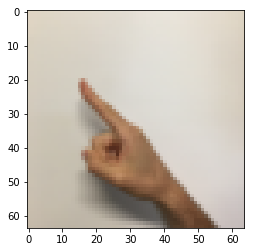

In [12]:
#USANDO A REDE PARA REALIZAR PREDIÇÕES

index = 10
index_cut = index+1

probs = sess.run(Dic_cg["softmax"], feed_dict={Dic_cg["placeholder_X"]: X_test[index:index_cut]})
print("Softmax da imagem abaixo é:", probs)

plt.imshow(X_test[index])

cla = sess.run(Dic_cg["class"], feed_dict={Dic_cg["placeholder_X"]: X_test[index:index_cut]})
print("A Classe é:", cla)



## 6 - Visualizando os mapas de features

Para visualizar os mapas de featuras das camadas de convolução, basta executar os tensores de convolução do Tensorflow e desenhar cada canal com o matplot.

Visualização da primeira camada de convolução
Saída do tensor: (1, 64, 64, 4)


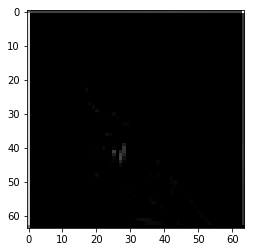

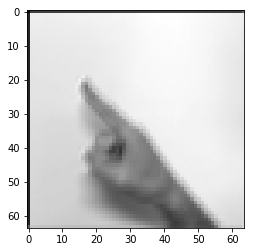

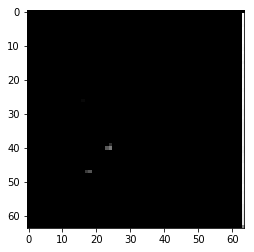

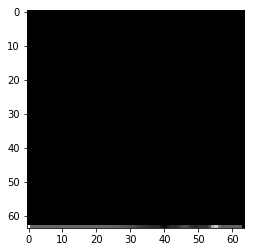

In [13]:
print("Visualização da primeira camada de convolução")
feature_maps = sess.run(Dic_cg["conv2d_1"], feed_dict={Dic_cg["placeholder_X"]: X_test[index:index_cut]})

print("Saída do tensor:",feature_maps.shape)
for c in range(feature_maps.shape[-1]):
    plt.imshow(feature_maps[0, :, :,c], cmap="gray")
    plt.pause(0.1)


Visualização da segunda camada de convolução
Saída do tensor: (1, 64, 64, 4)


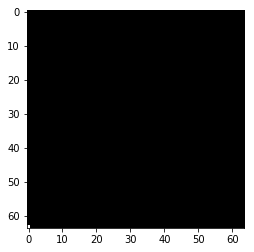

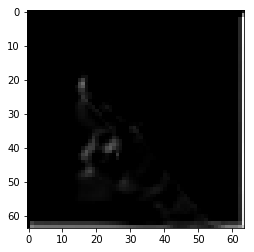

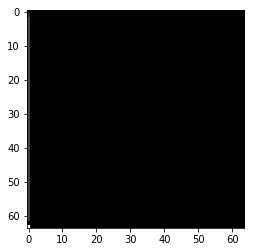

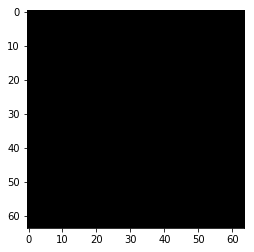

In [14]:
print("Visualização da segunda camada de convolução")
feature_maps = sess.run(Dic_cg["conv2d_2"], feed_dict={Dic_cg["placeholder_X"]: X_test[index:index_cut]})

print("Saída do tensor:",feature_maps.shape)
for c in range(feature_maps.shape[-1]):
    plt.imshow(feature_maps[0, :, :,c], cmap="gray")
    plt.pause(0.1)

Visualização da terceira camada de convolução
Saída do tensor: (1, 32, 32, 8)


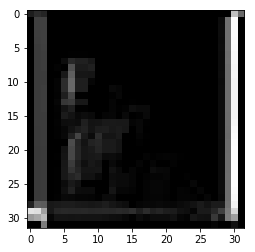

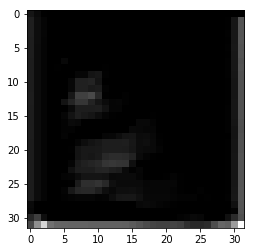

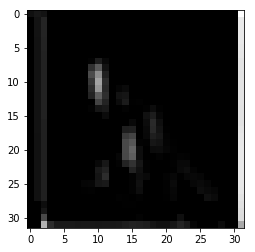

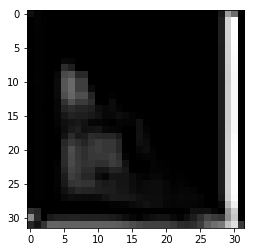

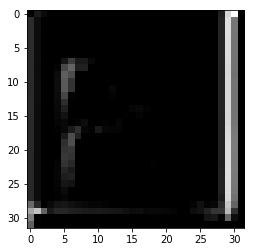

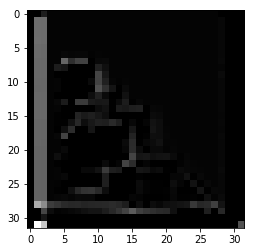

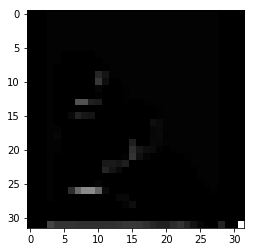

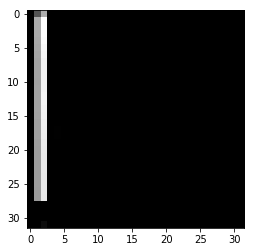

In [15]:
print("Visualização da terceira camada de convolução")
feature_maps = sess.run(Dic_cg["conv2d_3"], feed_dict={Dic_cg["placeholder_X"]: X_test[index:index_cut]})

print("Saída do tensor:",feature_maps.shape)
for c in range(feature_maps.shape[-1]):
    plt.imshow(feature_maps[0, :, :,c], cmap="gray")
    plt.pause(0.1)

Visualização da quarta camada de convolução
Saída do tensor: (1, 32, 32, 8)


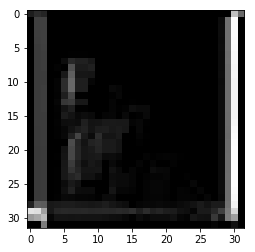

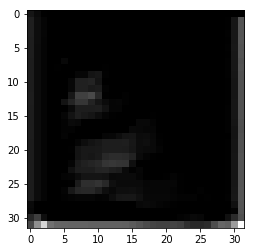

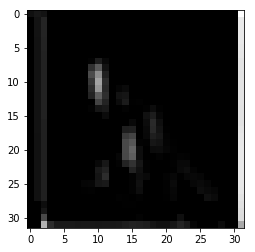

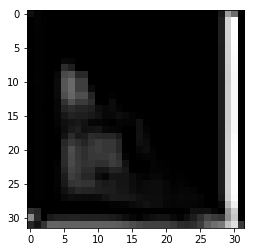

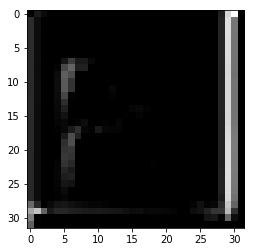

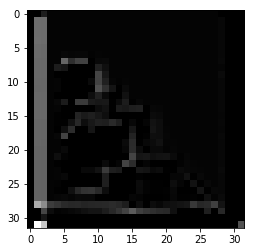

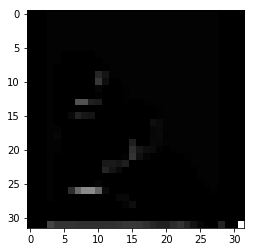

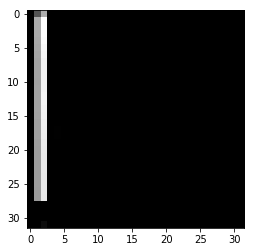

In [16]:
print("Visualização da quarta camada de convolução")
feature_maps = sess.run(Dic_cg["conv2d_4"], feed_dict={Dic_cg["placeholder_X"]: X_test[index:index_cut]})

print("Saída do tensor:",feature_maps.shape)
for c in range(feature_maps.shape[-1]):
    plt.imshow(feature_maps[0, :, :,c], cmap="gray")
    plt.pause(0.1)